In [26]:
# ✅ Critical imports and seed setting
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import pydicom
import io

# Fix reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [27]:
# ✅ Load data with stratified split for class imbalance
dataset_path = "/kaggle/input/rsna-pneumonia-detection-challenge"

# Load CSV files
labels_df = pd.read_csv(os.path.join(dataset_path, "stage_2_train_labels.csv"))
class_df = pd.read_csv(os.path.join(dataset_path, "stage_2_detailed_class_info.csv"))

# Merge and deduplicate
merged = pd.merge(labels_df[['patientId','Target']], class_df[['patientId','class']], on='patientId')
merged = merged.drop_duplicates('patientId').reset_index(drop=True)

# Stratified split (80-20)
train_df, val_df = train_test_split(
    merged, 
    test_size=0.2, 
    stratify=merged['Target'], 
    random_state=SEED
)

print(f"Train: {len(train_df)} | Val: {len(val_df)}")
print("Pneumonia ratio:", train_df['Target'].mean())

Train: 21347 | Val: 5337
Pneumonia ratio: 0.22532440155525366


In [28]:
# ✅ Fix: Explicit shape definition at every step

# 1. Get file paths and labels (same as before)
train_paths = [os.path.join(dataset_path, "stage_2_train_images", pid + ".dcm") for pid in train_df['patientId']]
train_labels = train_df['Target'].values.astype(np.int32)

val_paths = [os.path.join(dataset_path, "stage_2_train_images", pid + ".dcm") for pid in val_df['patientId']]
val_labels = val_df['Target'].values.astype(np.int32)

# 2. Create datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

# 3. Preprocessing with enforced shapes
def process_path(path, label):
    # Read DICOM bytes
    img_bytes = tf.io.read_file(path)
    
    # Decode DICOM and enforce shape
    img = tf.numpy_function(
        lambda x: pydicom.dcmread(io.BytesIO(x)).pixel_array.astype(np.float32),
        [img_bytes],
        tf.float32
    )
    img.set_shape((1024, 1024))  # ⚠️ Critical fix: Set shape here
    
    # Normalize
    img = (img - tf.reduce_min(img)) / (tf.reduce_max(img) - tf.reduce_min(img) + 1e-7)
    
    # Add channel dim + convert to RGB
    img = tf.expand_dims(img, axis=-1)  # (1024, 1024, 1)
    img = tf.image.grayscale_to_rgb(img)  # (1024, 1024, 3)
    
    # Resize with known shape
    img = tf.image.resize(img, [224, 224])  # Now works
    
    # Augmentation
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, 0.1)
    
    return img, label

# 4. Batch and prefetch
BATCH_SIZE = 32
train_ds = train_ds.map(process_path).shuffle(1000).batch(BATCH_SIZE).prefetch(2)
val_ds = val_ds.map(process_path).batch(BATCH_SIZE).prefetch(2)

In [29]:
# ✅ Handle class imbalance
class_counts = train_df['Target'].value_counts()
total = class_counts.sum()
class_weights = {
    0: total / (2 * class_counts[0]),  # Normal
    1: total / (2 * class_counts[1])   # Pneumonia
}
print("Class weights:", class_weights)

Class weights: {0: 0.6454314567333858, 1: 2.219022869022869}


In [30]:
# ✅ DenseNet201 with regularization
from tensorflow.keras import layers, models, applications

# 1. Base model (first 150 layers frozen)
base_model = applications.DenseNet201(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224, 224, 3)
)
for layer in base_model.layers[:150]:
    layer.trainable = False

# 2. Custom head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),  # Strong dropout
    layers.Dense(64, activation='relu', kernel_regularizer='l2'),
    layers.Dense(1, activation='sigmoid')
])

# 3. Compile with AdamW
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)             │ (None, 7, 7, 1920)          │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 1920)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1920)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │         122,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,444,993 (70.36 MB)

 Trainable params: 16,715,329 (63.76 MB)

 Non-trainable params: 1,729,664 (6.60 MB)

In [31]:
# ✅ Prevent overfitting via early stopping and LR scheduling
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(
        monitor='val_auc', 
        patience=5, 
        mode='max',  # Stop when AUC stops improving
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=2, 
        verbose=1
    )
]

# Calculate steps per epoch
steps_per_epoch = len(train_df) // BATCH_SIZE
val_steps = len(val_df) // BATCH_SIZE

# Train
history = model.fit(
    train_ds,
    epochs=30,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    class_weight=class_weights,  # Critical for imbalance
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
667/667 ━━━━━━━━━━━━━━━━━━━━ 994s 961ms/step - accuracy: 0.7373 - auc: 0.8208 - loss: 1.3587 - val_accuracy: 0.7581 - val_auc: 0.8749 - val_loss: 0.8298 - learning_rate: 1.0000e-04
Epoch 2/30
  1/667 ━━━━━━━━━━━━━━━━━━━━ 44:46:55 242s/step - accuracy: 1.0000 - auc: 0.0000e+00 - loss: 0.6730

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


667/667 ━━━━━━━━━━━━━━━━━━━━ 311s 104ms/step - accuracy: 1.0000 - auc: 0.0000e+00 - loss: 0.6730 - val_accuracy: 0.7581 - val_auc: 0.8749 - val_loss: 0.8272 - learning_rate: 1.0000e-04
Epoch 3/30
667/667 ━━━━━━━━━━━━━━━━━━━━ 399s 576ms/step - accuracy: 0.7799 - auc: 0.8743 - loss: 0.7681 - val_accuracy: 0.7658 - val_auc: 0.8772 - val_loss: 0.7348 - learning_rate: 1.0000e-04
Epoch 4/30
667/667 ━━━━━━━━━━━━━━━━━━━━ 70s 105ms/step - accuracy: 0.3333 - auc: 0.0000e+00 - loss: 0.8139 - val_accuracy: 0.7598 - val_auc: 0.8768 - val_loss: 0.7413 - learning_rate: 1.0000e-04
Epoch 5/30
667/667 ━━━━━━━━━━━━━━━━━━━━ 397s 574ms/step - accuracy: 0.7990 - auc: 0.9002 - loss: 0.6101 - val_accuracy: 0.7828 - val_auc: 0.8700 - val_loss: 0.5817 - learning_rate: 1.0000e-04
Epoch 6/30
667/667 ━━━━━━━━━━━━━━━━━━━━ 72s 107ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.6666 - val_accuracy: 0.7812 - val_auc: 0.8705 - val_loss: 0.5861 - learning_rate: 1.0000e-04
Epoch 7/30
667/667 ━━━━━━━━━━━━━━━━━━━━ 379s 

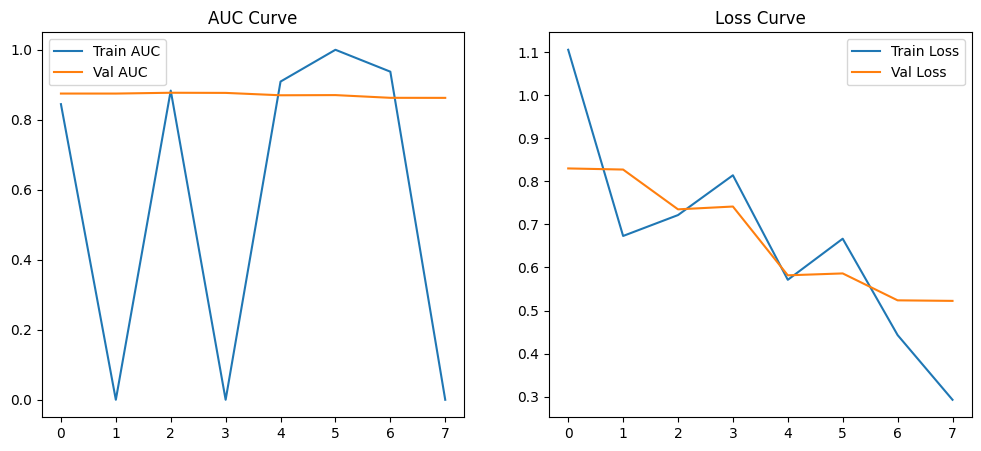

Classification Report:
               precision    recall  f1-score   support

      Normal       0.94      0.74      0.83      4135
   Pneumonia       0.49      0.84      0.62      1202

    accuracy                           0.77      5337
   macro avg       0.72      0.79      0.72      5337
weighted avg       0.84      0.77      0.78      5337

ROC-AUC: 0.8772153223064342


In [32]:
# ✅ Validate model performance on imbalanced data
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('AUC Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Generate predictions
y_true = []
y_pred = []
for images, labels in val_ds:
    y_true.extend(labels.numpy())
    y_pred.extend(model.predict(images, verbose=0).flatten())

# Classification report (focus on Pneumonia recall)
y_pred_class = (np.array(y_pred) > 0.5).astype(int)
print("Classification Report:\n", classification_report(y_true, y_pred_class, target_names=['Normal', 'Pneumonia']))

# ROC-AUC score
print("ROC-AUC:", roc_auc_score(y_true, y_pred))